In [32]:
# Load dependencies and mat.-files
from src import RelErrorTracker
import scipy.sparse.linalg as spla
import scipy.sparse as sp
import numpy as np
import scipy.io
import time
from matplotlib import pyplot as plt
import ilupp

try:
    from scikits.umfpack import spsolve
    print("using UMFPACK")
except:
    from scipy.sparse import spsolve
    print("NOT using UMFPACK")

mat = scipy.io.loadmat('../data/cooling_flange.mat')
A = mat["A"]
np.random.seed(0)
b = np.random.rand(A.shape[0])

using UMFPACK


### Display sparsity

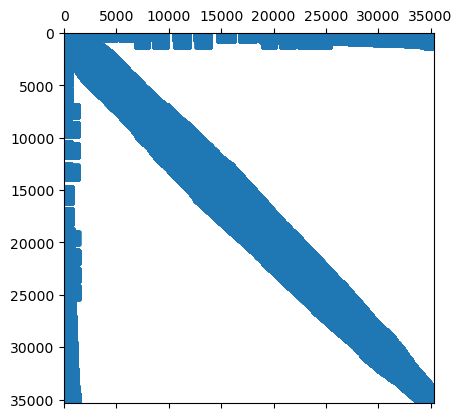

In [16]:
plt.spy(A)

### Linear (sparse) Solver:

In [33]:
t = time.time()
x_ls = spsolve(A,b)
dt = time.time() - t
print(f"Computation time linear solver: {dt} seconds. Relative error: {np.linalg.norm(A*x_ls-b)/np.linalg.norm(b)}")

Computation time linear solver: 1.2649476528167725 seconds. Relative error: 1.1671595424207634e-12


### Regular Conjugate Gradient:

In [34]:
relerror = 1e-4


t = time.time()
x_cg = spla.cg(A, b, tol = relerror)[0]
dt = time.time() - t
print(f"Computation time conjugate gradient: {dt} seconds. Relative error: {np.linalg.norm(A*x_cg-b)/np.linalg.norm(b)}")

# Additional run to measure convergence:
relerr_cg = RelErrorTracker(A,b)
_ = spla.cg(A, b, tol = relerror, callback = relerr_cg.callback)[0]

Computation time conjugate gradient: 2.938810110092163 seconds. Relative error: 9.584264343562433e-05


### PCG (M: diag)

In [36]:
M = sp.diags(A.diagonal()**(-1))
t = time.time()
x_pcgd = spla.cg(A, b, tol = relerror, M = M)[0]
dt = time.time() - t

print(f"Computation time preconditioned conjugate gradient: {dt} seconds. Relative error: {np.linalg.norm(A*x_pcgd-b)/np.linalg.norm(b)}")

# Additional run to measure convergence:
relerr_pcgd = RelErrorTracker(A,b)
_ = spla.cg(A, b, tol = relerror, M = M, callback=relerr_pcgd.callback)[0]

Computation time preconditioned conjugate gradient: 2.70839262008667 seconds. Relative error: 9.815044398512293e-05


### PCG (M: ichol)

In [39]:
M = ilupp.IChol0Preconditioner(sp.csr_matrix(A))
t = time.time()
x_pcgc = spla.cg(A, b, tol = relerror, M = M)[0]
dt = time.time() - t
print(f"Computation time preconditioned conjugate gradient: {dt} seconds. Relative error: {np.linalg.norm(A*x_pcgc-b)/np.linalg.norm(b)}")


# Additional run to measure convergence:
relerr_pcgc = RelErrorTracker(A,b)
_ = spla.cg(A, b, tol = relerror, M = M, callback=relerr_pcgc.callback)[0]

Computation time preconditioned conjugate gradient: 0.9031293392181396 seconds. Relative error: 8.812824235501841e-05


### Compare plots

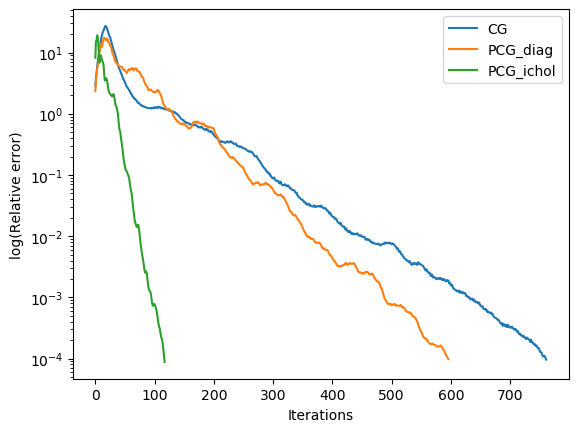

In [40]:
plt.semilogy(relerr_cg.norms)
plt.semilogy(relerr_pcgd.norms)
plt.semilogy(relerr_pcgc.norms)
plt.xlabel("Iterations")
plt.ylabel("log(Relative error)")
plt.legend(["CG","PCG_diag","PCG_ichol"])
plt.show()

### Part c

In [41]:
# Load mat.-files and display sparsity
mat = scipy.io.loadmat('../data/convdiff.mat')
A = mat["A"]
np.random.seed(4)
b = np.random.rand(A.shape[0])

### Display sparsity

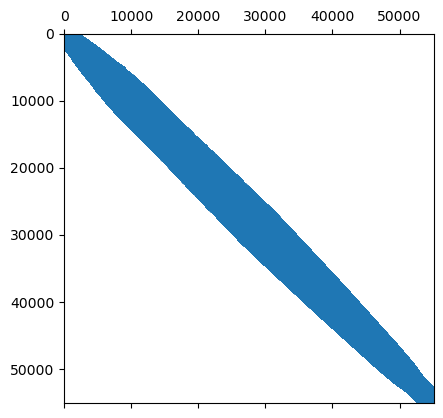

In [42]:
plt.spy(A)

### Linear (sparse) solver

In [43]:
# Linear solver:
t = time.time()
x = spsolve(A,b)
dt = time.time() - t
print(f"Computation time linear solver: {dt} seconds. Relative error: {np.linalg.norm(A*x-b)/np.linalg.norm(b)}")

Computation time linear solver: 2.7318007946014404 seconds. Relative error: 1.284651884539154e-12


#### GMRES with preconditioner:

In [44]:
M = ilupp.ILUTPreconditioner(sp.csr_matrix(A))
relerror = 1e-4

t = time.time()
x_gm = spla.gmres(A, b, tol = relerror, M=M, maxiter=3000)[0]
dt = time.time() - t
print(f"Computation time preconditioned gmres: {dt} seconds. Relative error: {np.linalg.norm(A*x_gm-b)/np.linalg.norm(b)}")


# Additional run to measure convergence:
relerr_gm = RelErrorTracker(A,b)
_ = spla.gmres(A, b, tol = relerror, M=M, callback=relerr_gm.callback, callback_type='x', maxiter=3000)[0]

Computation time preconditioned gmres: 2.187229871749878 seconds. Relative error: 2.983948242805057e-05


#### GMRES without preconditioner:

In [45]:
t = time.time()
x_gm_without = spla.gmres(A, b, tol = relerror, maxiter=3000)[0]
dt = time.time() - t
print(f"Computation time gmres: {dt} seconds. Relative error: {np.linalg.norm(A*x_gm_without-b)/np.linalg.norm(b)}")

# Additional run to measure convergence:
relerr_gm_without = RelErrorTracker(A,b)
x_gm_without = spla.gmres(A, b, tol = relerror, callback=relerr_gm_without.callback, callback_type = "x", maxiter=3000)[0]

Computation time gmres: 9.967301607131958 seconds. Relative error: 9.952762079300225e-05


## Compare plots GMRES

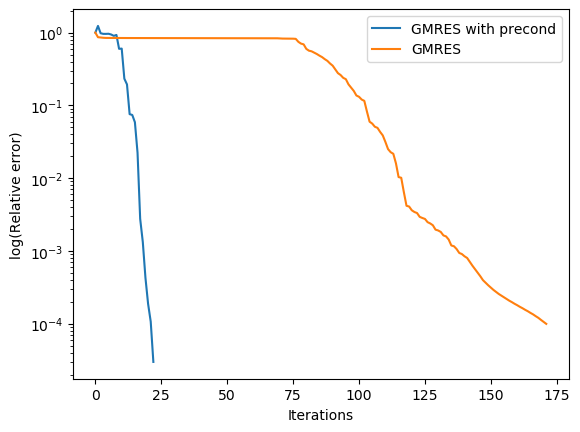

In [46]:
plt.semilogy(relerr_gm.norms)
plt.semilogy(relerr_gm_without.norms)
plt.xlabel("Iterations")
plt.ylabel("log(Relative error)")
plt.legend(["GMRES with precond","GMRES"])
plt.show()

### Using the package "ilupp"

In [47]:
t = time.time()
x_ilupp, info = ilupp.solve(sp.csr_matrix(A),b, info = True, rtol = relerror)
dt = time.time() - t
print(f"Computation time using ilupp: {dt} seconds. Relative error: {np.linalg.norm(A*x_ilupp-b)/np.linalg.norm(b)}")
print(f"ILUPP converged at {info[0]} iterations")

Computation time using ilupp: 0.5036261081695557 seconds. Relative error: 5.970692454008196e-07
ILUPP converged at 117 iterations
